# CASE STUDY 2 : Age Detection of Indian Actors

<b>Problem Statement</b>

Indian Movie Face database (IMFDB) is a large unconstrained face database consisting of 34512 images of 100 Indian actors collected from more than 100 videos. All the images are manually selected and cropped from the video frames resulting in a high degree of variability interms of scale, pose, expression, illumination, age, resolution, occlusion, and makeup. IMFDB is the first face database that provides a detailed annotation of every image in terms of age, pose, gender, expression and type of occlusion that may help other face related applications. For more details about the data set, read here



<b>Data</b>

The dataset is cleaned and formatted to give you a total of 26742 images with 19906 images in train and 6636 images in test.

The task is to predict the age of a person from his or her facial attributes. For simplicity, the problem has been converted to a multiclass problem with classes as Young, Middle and Old.



The attributes of data are as follows:
ID – Unique ID of image

Class – Age bin of person in image



In [1]:
import shutil, os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
from keras import Sequential
from keras.layers import Conv2D,Dropout,BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [2]:
#---- Reading file
train_csv = pd.read_csv("train.csv")
train_csv["Class"].unique()

array(['MIDDLE', 'YOUNG', 'OLD'], dtype=object)

In [56]:
#---- Reading file
test_csv = pd.read_csv("test.csv")
test_csv.head()

,ID
0,25321.jpg
1,989.jpg
2,19277.jpg
3,13093.jpg
4,5367.jpg


In [3]:
#--- Separating images in 3 classes

for index, row in train_csv.iterrows():
    shutil.copy2("Train/"+row["ID"],row["Class"] )

In [3]:
train_csv.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

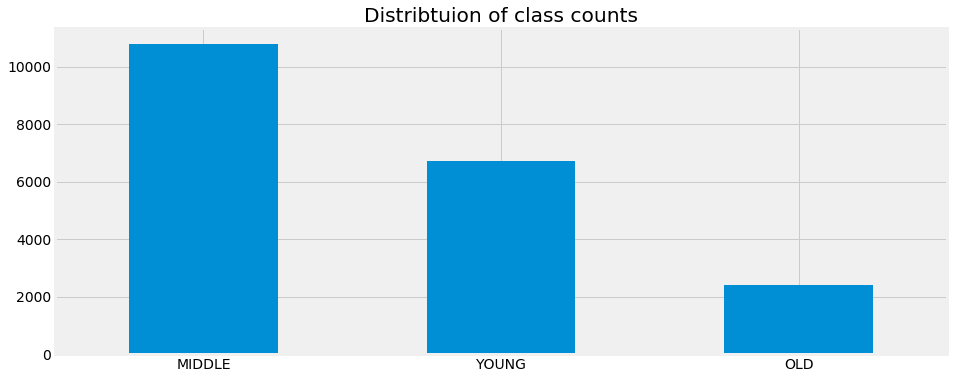

In [4]:
##inspecting the distribution of classes...
plt.figure(figsize = (16,6))
plt.style.use("fivethirtyeight")
train_csv['Class'].value_counts(dropna = False).plot(kind = 'bar',grid = True)
plt.title("Distribtuion of class counts")
plt.xticks(rotation = 0)

In [8]:
#----preparing validation set    
    
for img in os.listdir("MIDDLE")[:200]:
    shutil.copy2("MIDDLE/"+img,"validation_set/MIDDLE" )
    os.remove("MIDDLE/"+img)
    
    
for img in os.listdir("YOUNG")[:200]:
    shutil.copy2("YOUNG/"+img,"validation_set/YOUNG" )
    os.remove("YOUNG/"+img)


for img in os.listdir("OLD")[:200]:
    shutil.copy2("OLD/"+img,"validation_set/OLD" )
    os.remove("OLD/"+img)

In [85]:
batch_size=32

# To handle image loading problem
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=18,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('dataset/training',
                                                 target_size = (64, 64),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

validation_set = test_datagen.flow_from_directory('dataset/validation_set',
                                            target_size = (64, 64),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')

print(training_set.class_indices)

Found 19306 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
{'MIDDLE': 0, 'OLD': 1, 'YOUNG': 2}


## Base CNN 

In [74]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape = (64, 64, 3)))
model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3)))
model.add(LeakyReLU(alpha=0.3))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))

# Dropout
model.add(Dropout(0.4))

#Max Pooling

model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(LeakyReLU(alpha=0.3))
model.add(BatchNormalization())

# Dropout
model.add(Dropout(0.3))

#Flatten
model.add(Flatten())
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(64))

model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))

In [75]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 32)        18464     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 60, 60, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 32)        9248      
__________

In [76]:
# compiling the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [77]:
from time import time
from keras.callbacks import TensorBoard

tensorboard1=TensorBoard(log_dir='.\CNN'.format(time()), write_graph=True, write_images=True)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [79]:
history = model.fit_generator(training_set,
                         steps_per_epoch = len(training_set),
                         epochs = 30,
                         validation_data = validation_set,
                         validation_steps = len(validation_set),
                             callbacks=[tensorboard1],
                             verbose=2)

Epoch 1/30
 - 23s - loss: 1.1062 - acc: 0.5719 - val_loss: 0.9694 - val_acc: 0.5267
Epoch 2/30
 - 22s - loss: 0.8070 - acc: 0.6499 - val_loss: 0.9114 - val_acc: 0.5867
Epoch 3/30
 - 22s - loss: 0.7578 - acc: 0.6753 - val_loss: 0.8616 - val_acc: 0.6050
Epoch 4/30
 - 23s - loss: 0.7342 - acc: 0.6845 - val_loss: 0.8644 - val_acc: 0.6017
Epoch 5/30
 - 23s - loss: 0.7176 - acc: 0.6902 - val_loss: 0.8285 - val_acc: 0.5867
Epoch 6/30
 - 23s - loss: 0.7036 - acc: 0.7004 - val_loss: 0.9357 - val_acc: 0.5967
Epoch 7/30
 - 22s - loss: 0.7049 - acc: 0.6962 - val_loss: 0.7695 - val_acc: 0.6817
Epoch 8/30
 - 23s - loss: 0.6834 - acc: 0.7076 - val_loss: 0.9400 - val_acc: 0.6033
Epoch 9/30
 - 23s - loss: 0.6890 - acc: 0.7105 - val_loss: 0.8423 - val_acc: 0.6033
Epoch 10/30
 - 22s - loss: 0.6658 - acc: 0.7190 - val_loss: 0.7574 - val_acc: 0.6567
Epoch 11/30
 - 22s - loss: 0.6619 - acc: 0.7177 - val_loss: 0.8962 - val_acc: 0.6000
Epoch 12/30
 - 23s - loss: 0.6635 - acc: 0.7209 - val_loss: 0.7473 - val_a

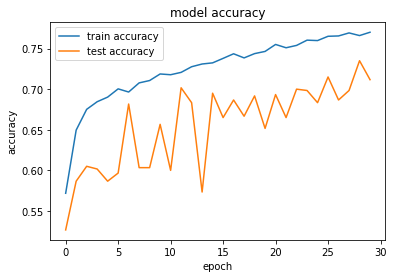

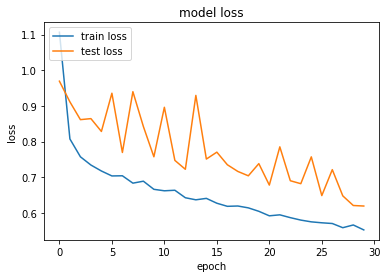

In [80]:
# summarize history for accuracy
epoch = range(len(history.history['acc']))
plt.plot(epoch,history.history['acc'],label="train accuracy")
plt.plot(epoch,history.history['val_acc'],label="test accuracy")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()
# summarize history for loss
plt.plot(epoch,history.history['loss'],label="train loss")
plt.plot(epoch,history.history['val_loss'],label="test loss" )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

In [5]:
# function to read images as arrays
def read_image(img_path, mode = 'color', resize = False, size = 64):
    '''
    Default mode is : color(BGR) --> color(RGB)
    Other modes allowed are : 'grayscale' and 'include_opacity'
    '''
    if mode == 'grayscale':
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    elif mode == 'include_opacity':
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    else:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if resize == True:
        img = cv2.resize(img, (size, size))
    
    return img

In [86]:
import os,sys
from PIL import Image
import cv2 #OpenCV library
from tqdm import tqdm

test = pd.read_csv("test.csv")
DATA_HOME_DIR = os.getcwd()
%pwd
TEST_PATH = DATA_HOME_DIR + '/Test/'
test_data = []
for img in tqdm(test['ID'].values):
    test_data.append(read_image(TEST_PATH + '{}'.format(img), resize = True, size = 64))

100%|█████████████████████████████████████████████████████████████████████████████| 6636/6636 [00:07<00:00, 922.62it/s]


In [87]:
X_test = np.array(test_data, np.float32) / 255.

In [42]:
# model.predict(x, batch_size=32, verbose=1, use_multiprocessing=True)
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis= 1)

In [43]:
predictions

array([0, 2, 1, ..., 0, 0, 1], dtype=int64)

In [100]:
train = pd.read_csv("train.csv")

unique_labels = np.unique(train['Class'].tolist())
pred_labels = unique_labels[predictions]

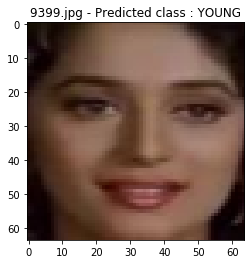

In [46]:
## Let's see what our classifier predicts on test images
# Random predictions
i = np.random.choice(np.arange(len(test_data)))
plt.title('{} - Predicted class : {}'.format(test['ID'].values[i], pred_labels[i]))
plt.imshow(test_data[i])

In [47]:
# Prepare submission file
subm = pd.DataFrame({'Class':pred_labels, 'ID':test.ID})
subm.to_csv('sub.csv', index=False)

## VGG19

In [8]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# re-size all the images to this
IMAGE_SIZE = [64, 64]

# add preprocessing layer to the front of VGG
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(3, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


from time import time
from tensorflow.keras.callbacks import TensorBoard

tensorboard2=TensorBoard(log_dir='.\VGG19'.format(time()), write_graph=True, write_images=True)

# fit the model
r = model.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set),
    callbacks=[tensorboard2])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

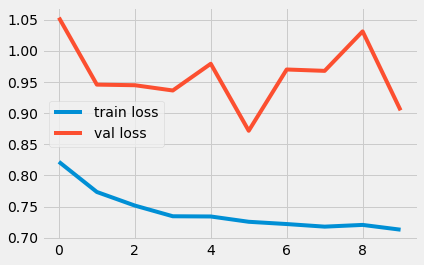

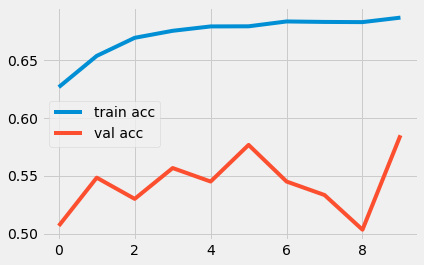

<Figure size 432x288 with 0 Axes>

In [9]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

## Resnet50

In [9]:
import os
from keras import Sequential,Model
from keras.layers import Dense,Flatten,MaxPooling2D,Convolution2D,Activation,BatchNormalization,Softmax,Dropout,GlobalMaxPool2D,GlobalAveragePooling2D
from keras import optimizers
import numpy as np
import sklearn
import random
from pathlib import Path

from keras import callbacks
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

In [10]:
Rsnt_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


C:\Users\Aditya\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


### Resnet Modified 1

In [88]:
av1 = GlobalAveragePooling2D()(Rsnt_model.output)
fc1 = Dense(256, activation='relu')(av1)

drp1=Dropout(0.3)(fc1)
fc2 = Dense(128, activation='relu')(drp1)
drp2=Dropout(0.5)(fc2)
bat_norm=BatchNormalization()(drp2)
fc3 = Dense(64, activation='relu')(bat_norm)
out = Dense(3, activation='softmax')(fc3)

tl_model = Model(inputs=Rsnt_model.input,outputs=out)
tl_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
bn3d_branch2c (BatchNormalizati (None, 8, 8, 512)    2048        res3d_branch2c[0][0]             
__________________________________________________________________________________________________
add_7 (Add)                     (None, 8, 8, 512)    0           bn3d_branch2c[0][0]              
                                                                 activation_19[0][0]              
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 8, 8, 512)    0           add_7[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 4, 4, 256)    131328      activation_22[0][0]              
__________________________________________________________________________________________________
bn4a_branc

__________________________________________________________________________________________________
bn5b_branch2a (BatchNormalizati (None, 2, 2, 512)    2048        res5b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 2, 2, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 2, 2, 512)    2359808     activation_44[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 2, 2, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 2, 2, 512)    0           bn5b_branch2b[0][0]              
__________

In [89]:
# ada = optimizers.adam(lr=1e-1, decay=5e-4)
tl_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [90]:
from time import time
from tensorflow.keras.callbacks import TensorBoard

tensorboard3=TensorBoard(log_dir='.\ResNet50'.format(time()), write_graph=True, write_images=True)

In [91]:
history = tl_model.fit_generator(training_set,
                         steps_per_epoch = len(training_set),
                         epochs = 30,
                         validation_data = validation_set,
                         validation_steps = len(validation_set),
                             callbacks=[tensorboard3],
                                verbose =2)

Epoch 1/30
 - 69s - loss: 0.8893 - acc: 0.6077 - val_loss: 0.9687 - val_acc: 0.5583
Epoch 2/30
 - 56s - loss: 0.7338 - acc: 0.6857 - val_loss: 1.0009 - val_acc: 0.5383
Epoch 3/30
 - 58s - loss: 0.6883 - acc: 0.7117 - val_loss: 0.9275 - val_acc: 0.6167
Epoch 4/30
 - 58s - loss: 0.6417 - acc: 0.7345 - val_loss: 0.8843 - val_acc: 0.6367
Epoch 5/30
 - 58s - loss: 0.6277 - acc: 0.7359 - val_loss: 1.2792 - val_acc: 0.5150
Epoch 6/30
 - 57s - loss: 0.6006 - acc: 0.7526 - val_loss: 0.8907 - val_acc: 0.5767
Epoch 7/30
 - 57s - loss: 0.5852 - acc: 0.7568 - val_loss: 0.8870 - val_acc: 0.5900
Epoch 8/30
 - 57s - loss: 0.5396 - acc: 0.7830 - val_loss: 1.1277 - val_acc: 0.5033
Epoch 9/30
 - 58s - loss: 0.5254 - acc: 0.7898 - val_loss: 0.7192 - val_acc: 0.6767
Epoch 10/30
 - 58s - loss: 0.4974 - acc: 0.7989 - val_loss: 0.6426 - val_acc: 0.7250
Epoch 11/30
 - 57s - loss: 0.4747 - acc: 0.8145 - val_loss: 0.5721 - val_acc: 0.7533
Epoch 12/30
 - 57s - loss: 0.4468 - acc: 0.8240 - val_loss: 0.6440 - val_a

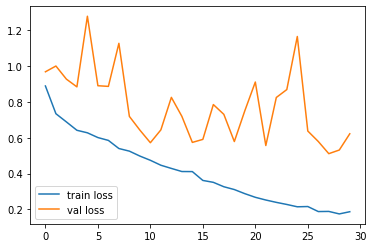

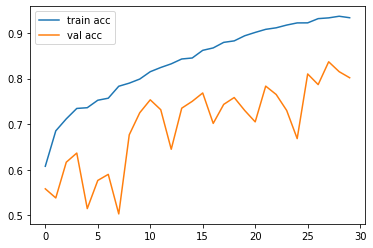

<Figure size 432x288 with 0 Axes>

In [92]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [108]:
# model.predict(x, batch_size=32, verbose=1, use_multiprocessing=True)
predictions = tl_model.predict(X_test)
predictions = np.argmax(predictions, axis= 1)



In [109]:
train = pd.read_csv("train.csv")

unique_labels = np.unique(train['Class'].tolist())
pred_labels = unique_labels[predictions]

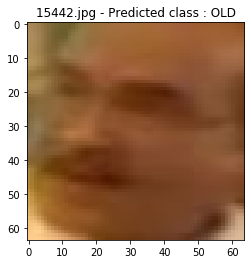

In [110]:
## Let's see what our classifier predicts on test images
# Random predictions
i = np.random.choice(np.arange(len(test_data)))
plt.title('{} - Predicted class : {}'.format(test['ID'].values[i], pred_labels[i]))
plt.imshow(test_data[i])

In [111]:
# Prepare submission file
subm = pd.DataFrame({'Class':pred_labels, 'ID':test.ID})
subm.to_csv('sub3.csv', index=False)

### Resnet Modified 2

In [90]:
av1 = GlobalAveragePooling2D()(Rsnt_model.output)
# fc1 = Dense(256, activation='relu')(av1)

# drp1=Dropout(0.35)(fc1)
fc2 = Dense(128, activation='relu')(av1)
drp2=Dropout(0.3)(fc2)
bat_norm=BatchNormalization()(drp2)

fc3 = Dense(68, activation='relu')(bat_norm)
drp3=Dropout(0.2)(fc3)
fc4 = Dense(32, activation='relu')(drp3)

out = Dense(3, activation='softmax')(fc4)

tl_model = Model(inputs=Rsnt_model.input,outputs=out)
tl_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
bn3d_branch2c (BatchNormalizati (None, 8, 8, 512)    2048        res3d_branch2c[0][0]             
__________________________________________________________________________________________________
add_39 (Add)                    (None, 8, 8, 512)    0           bn3d_branch2c[0][0]              
                                                                 activation_117[0][0]             
__________________________________________________________________________________________________
activation_120 (Activation)     (None, 8, 8, 512)    0           add_39[0][0]                     
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 4, 4, 256)    131328      activation_120[0][0]             
__________________________________________________________________________________________________
bn4a_branc

__________________________________________________________________________________________________
bn5b_branch2a (BatchNormalizati (None, 2, 2, 512)    2048        res5b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_142 (Activation)     (None, 2, 2, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 2, 2, 512)    2359808     activation_142[0][0]             
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 2, 2, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_143 (Activation)     (None, 2, 2, 512)    0           bn5b_branch2b[0][0]              
__________

In [91]:
# ada = optimizers.adam(lr=1e-1, decay=5e-4)
tl_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [92]:
from time import time
from tensorflow.keras.callbacks import TensorBoard

tensorboard3=TensorBoard(log_dir='.\ResNet50'.format(time()), write_graph=True, write_images=True)

In [93]:
history = tl_model.fit_generator(training_set,
                         steps_per_epoch = len(training_set),
                         epochs = 20,
                         validation_data = validation_set,
                         validation_steps = len(validation_set),
                             callbacks=[tensorboard3],
                                verbose =2)

Epoch 1/20
 - 76s - loss: 0.1073 - acc: 0.9639 - val_loss: 0.9142 - val_acc: 0.7933
Epoch 2/20
 - 57s - loss: 0.0783 - acc: 0.9739 - val_loss: 0.8959 - val_acc: 0.7917
Epoch 3/20
 - 57s - loss: 0.0793 - acc: 0.9727 - val_loss: 0.7700 - val_acc: 0.8033
Epoch 4/20
 - 57s - loss: 0.0708 - acc: 0.9750 - val_loss: 0.8396 - val_acc: 0.8083
Epoch 5/20
 - 56s - loss: 0.0764 - acc: 0.9745 - val_loss: 1.5182 - val_acc: 0.6617
Epoch 6/20
 - 56s - loss: 0.0717 - acc: 0.9750 - val_loss: 1.0071 - val_acc: 0.7583
Epoch 7/20
 - 57s - loss: 0.0655 - acc: 0.9784 - val_loss: 0.9436 - val_acc: 0.7933
Epoch 8/20
 - 57s - loss: 0.0657 - acc: 0.9776 - val_loss: 0.6743 - val_acc: 0.8433
Epoch 9/20
 - 56s - loss: 0.0676 - acc: 0.9775 - val_loss: 0.6661 - val_acc: 0.8283
Epoch 10/20
 - 56s - loss: 0.0653 - acc: 0.9787 - val_loss: 0.7988 - val_acc: 0.7967
Epoch 11/20
 - 56s - loss: 0.0652 - acc: 0.9772 - val_loss: 0.6426 - val_acc: 0.8617
Epoch 12/20
 - 56s - loss: 0.0651 - acc: 0.9770 - val_loss: 0.9328 - val_a

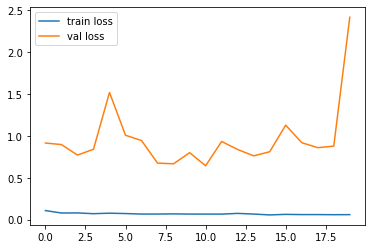

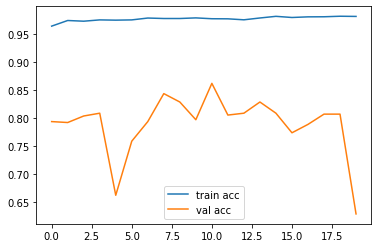

<Figure size 432x288 with 0 Axes>

In [95]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [96]:
# model.predict(x, batch_size=32, verbose=1, use_multiprocessing=True)
predictions = tl_model.predict(X_test)
predictions = np.argmax(predictions, axis= 1)

In [97]:
train = pd.read_csv("train.csv")

unique_labels = np.unique(train['Class'].tolist())
pred_labels = unique_labels[predictions]

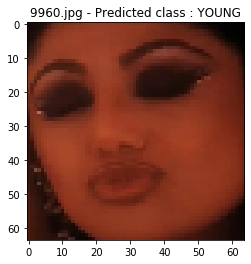

In [98]:
## Let's see what our classifier predicts on test images
# Random predictions
i = np.random.choice(np.arange(len(test_data)))
plt.title('{} - Predicted class : {}'.format(test['ID'].values[i], pred_labels[i]))
plt.imshow(test_data[i])

In [99]:
# Prepare submission file
subm = pd.DataFrame({'Class':pred_labels, 'ID':test.ID})
subm.to_csv('sub25.csv', index=False)

### Resnet Modified 3

In [97]:
av1 = GlobalAveragePooling2D()(Rsnt_model.output)

# fc1 = Dense(512, activation='relu')(av1)
# drp1=Dropout(0.6)(fc1)
# bat_norm1=BatchNormalization()(drp1)

# fc2 = Dense(256, activation='relu')(av1)
# drp2=Dropout(0.4)(fc2)
# bat_norm2=BatchNormalization()(drp2)
bat_norm=BatchNormalization()(av1)
# fc1 = Dense(236, activation='relu')(bat_norm)
# drp1=Dropout(0.35)(fc1)
fc3 = Dense(168, activation='relu')(bat_norm)
drp3=Dropout(0.25)(fc3)
bat_norm3=BatchNormalization()(drp3)

fc4 = Dense(68, activation='relu')(bat_norm3)
out = Dense(3, activation='softmax')(fc4)

tl_model = Model(inputs=Rsnt_model.input,outputs=out)
tl_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

activation_10 (Activation)      (None, 16, 16, 256)  0           add_3[0][0]                      
__________________________________________________________________________________________________
res3a_branch2a (Conv2D)         (None, 8, 8, 128)    32896       activation_10[0][0]              
__________________________________________________________________________________________________
bn3a_branch2a (BatchNormalizati (None, 8, 8, 128)    512         res3a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 8, 8, 128)    0           bn3a_branch2a[0][0]              
__________________________________________________________________________________________________
res3a_branch2b (Conv2D)         (None, 8, 8, 128)    147584      activation_11[0][0]              
__________________________________________________________________________________________________
bn3a_branc

__________________________________________________________________________________________________
bn3d_branch2c (BatchNormalizati (None, 8, 8, 512)    2048        res3d_branch2c[0][0]             
__________________________________________________________________________________________________
add_7 (Add)                     (None, 8, 8, 512)    0           bn3d_branch2c[0][0]              
                                                                 activation_19[0][0]              
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 8, 8, 512)    0           add_7[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 4, 4, 256)    131328      activation_22[0][0]              
__________________________________________________________________________________________________
bn4a_branc

__________________________________________________________________________________________________
bn4d_branch2b (BatchNormalizati (None, 4, 4, 256)    1024        res4d_branch2b[0][0]             
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 4, 4, 256)    0           bn4d_branch2b[0][0]              
__________________________________________________________________________________________________
res4d_branch2c (Conv2D)         (None, 4, 4, 1024)   263168      activation_33[0][0]              
__________________________________________________________________________________________________
bn4d_branch2c (BatchNormalizati (None, 4, 4, 1024)   4096        res4d_branch2c[0][0]             
__________________________________________________________________________________________________
add_11 (Add)                    (None, 4, 4, 1024)   0           bn4d_branch2c[0][0]              
          

__________________________________________________________________________________________________
bn5b_branch2a (BatchNormalizati (None, 2, 2, 512)    2048        res5b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 2, 2, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 2, 2, 512)    2359808     activation_44[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 2, 2, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 2, 2, 512)    0           bn5b_branch2b[0][0]              
__________

In [98]:
# ada = optimizers.adam(lr=1e-1, decay=5e-4)
tl_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [99]:
from time import time
from tensorflow.keras.callbacks import TensorBoard

tensorboard3=TensorBoard(log_dir='.\ResNet50'.format(time()), write_graph=True, write_images=True)

In [106]:
history = tl_model.fit_generator(training_set,
                         steps_per_epoch = len(training_set),
                         epochs = 25,
                         validation_data = validation_set,
                         validation_steps = len(validation_set),
                             callbacks=[tensorboard3],
                                verbose =2)

Epoch 1/25
 - 56s - loss: 0.0342 - acc: 0.9886 - val_loss: 0.6827 - val_acc: 0.8383
Epoch 2/25
 - 56s - loss: 0.0389 - acc: 0.9870 - val_loss: 0.6304 - val_acc: 0.8533
Epoch 3/25
 - 56s - loss: 0.0315 - acc: 0.9902 - val_loss: 0.9470 - val_acc: 0.8050
Epoch 4/25
 - 57s - loss: 0.0285 - acc: 0.9903 - val_loss: 0.6711 - val_acc: 0.8433
Epoch 5/25
 - 57s - loss: 0.0247 - acc: 0.9916 - val_loss: 0.7934 - val_acc: 0.8167
Epoch 6/25
 - 58s - loss: 0.0312 - acc: 0.9888 - val_loss: 1.1520 - val_acc: 0.8050
Epoch 7/25
 - 58s - loss: 0.0354 - acc: 0.9885 - val_loss: 0.7480 - val_acc: 0.8367
Epoch 8/25
 - 58s - loss: 0.0266 - acc: 0.9909 - val_loss: 0.8357 - val_acc: 0.8017
Epoch 9/25
 - 58s - loss: 0.0277 - acc: 0.9902 - val_loss: 1.0135 - val_acc: 0.7633
Epoch 10/25
 - 58s - loss: 0.0364 - acc: 0.9892 - val_loss: 1.2657 - val_acc: 0.7017
Epoch 11/25
 - 58s - loss: 0.0337 - acc: 0.9890 - val_loss: 0.6791 - val_acc: 0.8417
Epoch 12/25
 - 58s - loss: 0.0285 - acc: 0.9901 - val_loss: 0.8360 - val_a

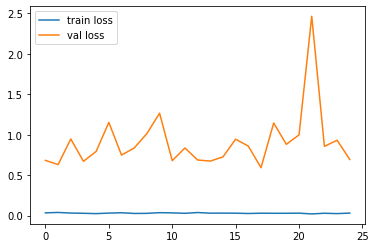

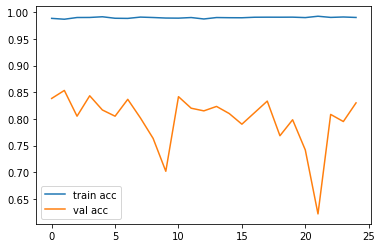

<Figure size 432x288 with 0 Axes>

In [107]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [108]:
# model.predict(x, batch_size=32, verbose=1, use_multiprocessing=True)
predictions = tl_model.predict(X_test)
predictions = np.argmax(predictions, axis= 1)

In [109]:
train = pd.read_csv("train.csv")

unique_labels = np.unique(train['Class'].tolist())
pred_labels = unique_labels[predictions]

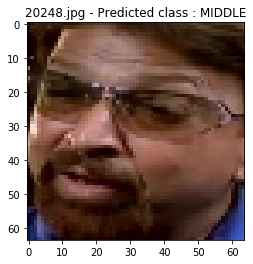

In [110]:
## Let's see what our classifier predicts on test images
# Random predictions
i = np.random.choice(np.arange(len(test_data)))
plt.title('{} - Predicted class : {}'.format(test['ID'].values[i], pred_labels[i]))
plt.imshow(test_data[i])

In [111]:
# Prepare submission file
subm = pd.DataFrame({'Class':pred_labels, 'ID':test.ID})
subm.to_csv('sub37.csv', index=False)

## InceptionResnet 

In [112]:
batch_size=32

# To handle image loading problem
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('dataset/training',
                                                 target_size = (75, 75),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

validation_set = test_datagen.flow_from_directory('dataset/validation_set',
                                            target_size = (75, 75),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')

print(training_set.class_indices)

Found 19306 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
{'MIDDLE': 0, 'OLD': 1, 'YOUNG': 2}


In [114]:
from keras.applications import InceptionResNetV2
irn = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(75,75,3), classes=3)

In [115]:
av1 = GlobalAveragePooling2D()(irn.output)
fc1 = Dense(256, activation='relu')(av1)
drp1=Dropout(0.3)(fc1)
fc2 = Dense(128, activation='relu')(drp1)
drp2=Dropout(0.5)(fc2)
bat_norm=BatchNormalization()(drp2)
fc3 = Dense(64, activation='relu')(bat_norm)
out = Dense(3, activation='softmax')(fc3)

tl_model = Model(inputs=irn.input,outputs=out)
tl_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 37, 37, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 37, 37, 32)   96          conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 37, 37, 32)   0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
conv2d_17 

__________________________________________________________________________________________________
activation_68 (Activation)      (None, 7, 7, 32)     0           batch_normalization_27[0][0]     
__________________________________________________________________________________________________
activation_70 (Activation)      (None, 7, 7, 32)     0           batch_normalization_29[0][0]     
__________________________________________________________________________________________________
activation_73 (Activation)      (None, 7, 7, 64)     0           batch_normalization_32[0][0]     
__________________________________________________________________________________________________
block35_2_mixed (Concatenate)   (None, 7, 7, 128)    0           activation_68[0][0]              
                                                                 activation_70[0][0]              
                                                                 activation_73[0][0]              
__________

__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 7, 7, 32)     10240       block35_5_ac[0][0]               
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 7, 7, 48)     13824       activation_95[0][0]              
__________________________________________________________________________________________________
batch_normalization_52 (BatchNo (None, 7, 7, 32)     96          conv2d_59[0][0]                  
__________________________________________________________________________________________________
batch_normalization_55 (BatchNo (None, 7, 7, 48)     144         conv2d_62[0][0]                  
__________________________________________________________________________________________________
activation_93 (Activation)      (None, 7, 7, 32)     0           batch_normalization_52[0][0]     
__________

batch_normalization_74 (BatchNo (None, 7, 7, 64)     192         conv2d_81[0][0]                  
__________________________________________________________________________________________________
activation_110 (Activation)     (None, 7, 7, 32)     0           batch_normalization_69[0][0]     
__________________________________________________________________________________________________
activation_112 (Activation)     (None, 7, 7, 32)     0           batch_normalization_71[0][0]     
__________________________________________________________________________________________________
activation_115 (Activation)     (None, 7, 7, 64)     0           batch_normalization_74[0][0]     
__________________________________________________________________________________________________
block35_9_mixed (Concatenate)   (None, 7, 7, 128)    0           activation_110[0][0]             
                                                                 activation_112[0][0]             
          

conv2d_101 (Conv2D)             (None, 3, 3, 128)    139264      block17_2_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 3, 3, 128)    384         conv2d_101[0][0]                 
__________________________________________________________________________________________________
activation_135 (Activation)     (None, 3, 3, 128)    0           batch_normalization_94[0][0]     
__________________________________________________________________________________________________
conv2d_102 (Conv2D)             (None, 3, 3, 160)    143360      activation_135[0][0]             
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 3, 3, 160)    480         conv2d_102[0][0]                 
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
block17_7 (Lambda)              (None, 3, 3, 1088)   0           block17_6_ac[0][0]               
                                                                 block17_7_conv[0][0]             
__________________________________________________________________________________________________
block17_7_ac (Activation)       (None, 3, 3, 1088)   0           block17_7[0][0]                  
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 3, 3, 128)    139264      block17_7_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_114 (BatchN (None, 3, 3, 128)    384         conv2d_121[0][0]                 
__________________________________________________________________________________________________
activation

activation_173 (Activation)     (None, 3, 3, 192)    0           batch_normalization_132[0][0]    
__________________________________________________________________________________________________
block17_12_mixed (Concatenate)  (None, 3, 3, 384)    0           activation_170[0][0]             
                                                                 activation_173[0][0]             
__________________________________________________________________________________________________
block17_12_conv (Conv2D)        (None, 3, 3, 1088)   418880      block17_12_mixed[0][0]           
__________________________________________________________________________________________________
block17_12 (Lambda)             (None, 3, 3, 1088)   0           block17_11_ac[0][0]              
                                                                 block17_12_conv[0][0]            
__________________________________________________________________________________________________
block17_12

batch_normalization_149 (BatchN (None, 3, 3, 192)    576         conv2d_156[0][0]                 
__________________________________________________________________________________________________
batch_normalization_152 (BatchN (None, 3, 3, 192)    576         conv2d_159[0][0]                 
__________________________________________________________________________________________________
activation_190 (Activation)     (None, 3, 3, 192)    0           batch_normalization_149[0][0]    
__________________________________________________________________________________________________
activation_193 (Activation)     (None, 3, 3, 192)    0           batch_normalization_152[0][0]    
__________________________________________________________________________________________________
block17_17_mixed (Concatenate)  (None, 3, 3, 384)    0           activation_190[0][0]             
                                                                 activation_193[0][0]             
__________

mixed_7a (Concatenate)          (None, 1, 1, 2080)   0           activation_207[0][0]             
                                                                 activation_209[0][0]             
                                                                 activation_212[0][0]             
                                                                 max_pooling2d_11[0][0]           
__________________________________________________________________________________________________
conv2d_180 (Conv2D)             (None, 1, 1, 192)    399360      mixed_7a[0][0]                   
__________________________________________________________________________________________________
batch_normalization_173 (BatchN (None, 1, 1, 192)    576         conv2d_180[0][0]                 
__________________________________________________________________________________________________
activation_214 (Activation)     (None, 1, 1, 192)    0           batch_normalization_173[0][0]    
__________

__________________________________________________________________________________________________
block8_5_mixed (Concatenate)    (None, 1, 1, 448)    0           activation_229[0][0]             
                                                                 activation_232[0][0]             
__________________________________________________________________________________________________
block8_5_conv (Conv2D)          (None, 1, 1, 2080)   933920      block8_5_mixed[0][0]             
__________________________________________________________________________________________________
block8_5 (Lambda)               (None, 1, 1, 2080)   0           block8_4_ac[0][0]                
                                                                 block8_5_conv[0][0]              
__________________________________________________________________________________________________
block8_5_ac (Activation)        (None, 1, 1, 2080)   0           block8_5[0][0]                   
__________

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [116]:
tl_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [117]:
from time import time
from tensorflow.keras.callbacks import TensorBoard

tensorboard4=TensorBoard(log_dir='.\Incep'.format(time()), write_graph=True, write_images=True)

In [120]:
history = tl_model.fit_generator(training_set,
                         steps_per_epoch = len(training_set),
                         epochs = 25,
                         validation_data = validation_set,
                         validation_steps = len(validation_set),
                             callbacks=[tensorboard4])

Epoch 1/25
204/604 [=========>....................] - ETA: 3:17 - loss: 0.3144 - acc: 0.843 - ETA: 2:43 - loss: 0.4382 - acc: 0.796 - ETA: 2:31 - loss: 0.4365 - acc: 0.812 - ETA: 2:25 - loss: 0.4470 - acc: 0.828 - ETA: 2:21 - loss: 0.4684 - acc: 0.812 - ETA: 2:19 - loss: 0.4708 - acc: 0.812 - ETA: 2:17 - loss: 0.5113 - acc: 0.790 - ETA: 2:15 - loss: 0.5413 - acc: 0.777 - ETA: 2:14 - loss: 0.5241 - acc: 0.777 - ETA: 2:13 - loss: 0.5077 - acc: 0.784 - ETA: 2:12 - loss: 0.4881 - acc: 0.801 - ETA: 2:12 - loss: 0.4786 - acc: 0.809 - ETA: 2:11 - loss: 0.4628 - acc: 0.817 - ETA: 2:10 - loss: 0.4566 - acc: 0.819 - ETA: 2:10 - loss: 0.4597 - acc: 0.818 - ETA: 2:09 - loss: 0.4538 - acc: 0.820 - ETA: 2:09 - loss: 0.4496 - acc: 0.819 - ETA: 2:08 - loss: 0.4533 - acc: 0.816 - ETA: 2:08 - loss: 0.4513 - acc: 0.817 - ETA: 2:07 - loss: 0.4580 - acc: 0.812 - ETA: 2:07 - loss: 0.4615 - acc: 0.808 - ETA: 2:06 - loss: 0.4664 - acc: 0.804 - ETA: 2:06 - loss: 0.4634 - acc: 0.804 - ETA: 2:06 - loss: 0.4646 -

204/604 [=========>....................] - ETA: 2:11 - loss: 0.2774 - acc: 0.906 - ETA: 2:10 - loss: 0.3470 - acc: 0.890 - ETA: 2:11 - loss: 0.4180 - acc: 0.864 - ETA: 2:10 - loss: 0.4837 - acc: 0.843 - ETA: 2:10 - loss: 0.5143 - acc: 0.812 - ETA: 2:10 - loss: 0.5472 - acc: 0.791 - ETA: 2:09 - loss: 0.5541 - acc: 0.794 - ETA: 2:09 - loss: 0.5772 - acc: 0.789 - ETA: 2:09 - loss: 0.5533 - acc: 0.798 - ETA: 2:08 - loss: 0.5386 - acc: 0.806 - ETA: 2:08 - loss: 0.5299 - acc: 0.809 - ETA: 2:07 - loss: 0.5220 - acc: 0.812 - ETA: 2:07 - loss: 0.5285 - acc: 0.802 - ETA: 2:07 - loss: 0.5193 - acc: 0.799 - ETA: 2:06 - loss: 0.5167 - acc: 0.804 - ETA: 2:06 - loss: 0.5142 - acc: 0.802 - ETA: 2:06 - loss: 0.5083 - acc: 0.801 - ETA: 2:05 - loss: 0.5081 - acc: 0.807 - ETA: 2:05 - loss: 0.5143 - acc: 0.802 - ETA: 2:05 - loss: 0.5101 - acc: 0.804 - ETA: 2:04 - loss: 0.5064 - acc: 0.806 - ETA: 2:04 - loss: 0.4972 - acc: 0.809 - ETA: 2:04 - loss: 0.5058 - acc: 0.801 - ETA: 2:03 - loss: 0.5151 - acc: 0.798

604/604 [==============================] - ETA: 40s - loss: 0.4579 - acc: 0.81 - ETA: 40s - loss: 0.4580 - acc: 0.81 - ETA: 40s - loss: 0.4578 - acc: 0.81 - ETA: 40s - loss: 0.4578 - acc: 0.81 - ETA: 40s - loss: 0.4578 - acc: 0.81 - ETA: 39s - loss: 0.4572 - acc: 0.81 - ETA: 39s - loss: 0.4572 - acc: 0.81 - ETA: 39s - loss: 0.4571 - acc: 0.81 - ETA: 39s - loss: 0.4571 - acc: 0.81 - ETA: 38s - loss: 0.4570 - acc: 0.81 - ETA: 38s - loss: 0.4574 - acc: 0.81 - ETA: 38s - loss: 0.4575 - acc: 0.81 - ETA: 38s - loss: 0.4572 - acc: 0.81 - ETA: 38s - loss: 0.4573 - acc: 0.81 - ETA: 37s - loss: 0.4574 - acc: 0.81 - ETA: 37s - loss: 0.4569 - acc: 0.81 - ETA: 37s - loss: 0.4568 - acc: 0.81 - ETA: 37s - loss: 0.4570 - acc: 0.81 - ETA: 37s - loss: 0.4570 - acc: 0.81 - ETA: 36s - loss: 0.4571 - acc: 0.81 - ETA: 36s - loss: 0.4570 - acc: 0.81 - ETA: 36s - loss: 0.4576 - acc: 0.81 - ETA: 36s - loss: 0.4574 - acc: 0.81 - ETA: 35s - loss: 0.4572 - acc: 0.81 - ETA: 35s - loss: 0.4572 - acc: 0.81 - ETA: 35

204/604 [=========>....................] - ETA: 2:06 - loss: 0.4212 - acc: 0.843 - ETA: 2:05 - loss: 0.4166 - acc: 0.859 - ETA: 2:06 - loss: 0.4380 - acc: 0.822 - ETA: 2:07 - loss: 0.4526 - acc: 0.796 - ETA: 2:07 - loss: 0.4689 - acc: 0.800 - ETA: 2:07 - loss: 0.4544 - acc: 0.802 - ETA: 2:06 - loss: 0.4585 - acc: 0.812 - ETA: 2:06 - loss: 0.4707 - acc: 0.812 - ETA: 2:05 - loss: 0.4783 - acc: 0.809 - ETA: 2:05 - loss: 0.4728 - acc: 0.815 - ETA: 2:06 - loss: 0.4631 - acc: 0.823 - ETA: 2:06 - loss: 0.4709 - acc: 0.820 - ETA: 2:06 - loss: 0.4795 - acc: 0.817 - ETA: 2:07 - loss: 0.4957 - acc: 0.812 - ETA: 2:07 - loss: 0.4894 - acc: 0.814 - ETA: 2:07 - loss: 0.4971 - acc: 0.812 - ETA: 2:07 - loss: 0.4887 - acc: 0.816 - ETA: 2:07 - loss: 0.4865 - acc: 0.817 - ETA: 2:06 - loss: 0.4813 - acc: 0.815 - ETA: 2:06 - loss: 0.4811 - acc: 0.814 - ETA: 2:06 - loss: 0.4806 - acc: 0.815 - ETA: 2:06 - loss: 0.4833 - acc: 0.815 - ETA: 2:06 - loss: 0.4782 - acc: 0.816 - ETA: 2:06 - loss: 0.4812 - acc: 0.813

604/604 [==============================] - ETA: 41s - loss: 0.4375 - acc: 0.82 - ETA: 40s - loss: 0.4375 - acc: 0.82 - ETA: 40s - loss: 0.4371 - acc: 0.82 - ETA: 40s - loss: 0.4374 - acc: 0.82 - ETA: 40s - loss: 0.4379 - acc: 0.82 - ETA: 40s - loss: 0.4379 - acc: 0.82 - ETA: 39s - loss: 0.4380 - acc: 0.82 - ETA: 39s - loss: 0.4379 - acc: 0.82 - ETA: 39s - loss: 0.4384 - acc: 0.82 - ETA: 39s - loss: 0.4381 - acc: 0.82 - ETA: 38s - loss: 0.4382 - acc: 0.82 - ETA: 38s - loss: 0.4381 - acc: 0.82 - ETA: 38s - loss: 0.4379 - acc: 0.82 - ETA: 38s - loss: 0.4376 - acc: 0.82 - ETA: 38s - loss: 0.4374 - acc: 0.82 - ETA: 37s - loss: 0.4369 - acc: 0.82 - ETA: 37s - loss: 0.4367 - acc: 0.82 - ETA: 37s - loss: 0.4364 - acc: 0.82 - ETA: 37s - loss: 0.4367 - acc: 0.82 - ETA: 37s - loss: 0.4366 - acc: 0.82 - ETA: 36s - loss: 0.4363 - acc: 0.82 - ETA: 36s - loss: 0.4366 - acc: 0.82 - ETA: 36s - loss: 0.4365 - acc: 0.82 - ETA: 36s - loss: 0.4365 - acc: 0.82 - ETA: 35s - loss: 0.4360 - acc: 0.82 - ETA: 35

204/604 [=========>....................] - ETA: 2:06 - loss: 0.4321 - acc: 0.812 - ETA: 2:05 - loss: 0.4653 - acc: 0.781 - ETA: 2:04 - loss: 0.4315 - acc: 0.791 - ETA: 2:05 - loss: 0.3962 - acc: 0.828 - ETA: 2:05 - loss: 0.3858 - acc: 0.843 - ETA: 2:05 - loss: 0.3617 - acc: 0.859 - ETA: 2:04 - loss: 0.3455 - acc: 0.870 - ETA: 2:04 - loss: 0.3501 - acc: 0.871 - ETA: 2:04 - loss: 0.3665 - acc: 0.868 - ETA: 2:04 - loss: 0.3520 - acc: 0.871 - ETA: 2:04 - loss: 0.3561 - acc: 0.872 - ETA: 2:04 - loss: 0.3667 - acc: 0.869 - ETA: 2:04 - loss: 0.3737 - acc: 0.863 - ETA: 2:04 - loss: 0.3752 - acc: 0.852 - ETA: 2:04 - loss: 0.3688 - acc: 0.852 - ETA: 2:04 - loss: 0.3783 - acc: 0.847 - ETA: 2:04 - loss: 0.3783 - acc: 0.843 - ETA: 2:04 - loss: 0.3797 - acc: 0.843 - ETA: 2:03 - loss: 0.3722 - acc: 0.847 - ETA: 2:03 - loss: 0.3706 - acc: 0.851 - ETA: 2:03 - loss: 0.3641 - acc: 0.854 - ETA: 2:03 - loss: 0.3671 - acc: 0.855 - ETA: 2:02 - loss: 0.3702 - acc: 0.851 - ETA: 2:02 - loss: 0.3705 - acc: 0.850

604/604 [==============================] - ETA: 42s - loss: 0.3888 - acc: 0.84 - ETA: 42s - loss: 0.3886 - acc: 0.84 - ETA: 41s - loss: 0.3893 - acc: 0.84 - ETA: 41s - loss: 0.3894 - acc: 0.84 - ETA: 41s - loss: 0.3890 - acc: 0.84 - ETA: 41s - loss: 0.3887 - acc: 0.84 - ETA: 41s - loss: 0.3886 - acc: 0.84 - ETA: 40s - loss: 0.3886 - acc: 0.84 - ETA: 40s - loss: 0.3887 - acc: 0.84 - ETA: 40s - loss: 0.3889 - acc: 0.84 - ETA: 40s - loss: 0.3885 - acc: 0.84 - ETA: 39s - loss: 0.3893 - acc: 0.84 - ETA: 39s - loss: 0.3892 - acc: 0.84 - ETA: 39s - loss: 0.3893 - acc: 0.84 - ETA: 39s - loss: 0.3891 - acc: 0.84 - ETA: 39s - loss: 0.3888 - acc: 0.84 - ETA: 38s - loss: 0.3892 - acc: 0.84 - ETA: 38s - loss: 0.3892 - acc: 0.84 - ETA: 38s - loss: 0.3891 - acc: 0.84 - ETA: 38s - loss: 0.3891 - acc: 0.84 - ETA: 37s - loss: 0.3891 - acc: 0.84 - ETA: 37s - loss: 0.3889 - acc: 0.84 - ETA: 37s - loss: 0.3891 - acc: 0.84 - ETA: 37s - loss: 0.3892 - acc: 0.84 - ETA: 37s - loss: 0.3891 - acc: 0.84 - ETA: 36

204/604 [=========>....................] - ETA: 2:15 - loss: 1.1612 - acc: 0.468 - ETA: 2:18 - loss: 0.7320 - acc: 0.656 - ETA: 2:18 - loss: 0.6167 - acc: 0.718 - ETA: 2:17 - loss: 0.5683 - acc: 0.734 - ETA: 2:17 - loss: 0.5436 - acc: 0.756 - ETA: 2:17 - loss: 0.4929 - acc: 0.781 - ETA: 2:15 - loss: 0.4812 - acc: 0.790 - ETA: 2:14 - loss: 0.4925 - acc: 0.777 - ETA: 2:13 - loss: 0.4966 - acc: 0.770 - ETA: 2:12 - loss: 0.4871 - acc: 0.778 - ETA: 2:12 - loss: 0.4722 - acc: 0.786 - ETA: 2:11 - loss: 0.4811 - acc: 0.789 - ETA: 2:11 - loss: 0.4705 - acc: 0.793 - ETA: 2:10 - loss: 0.4506 - acc: 0.808 - ETA: 2:10 - loss: 0.4451 - acc: 0.814 - ETA: 2:10 - loss: 0.4489 - acc: 0.816 - ETA: 2:10 - loss: 0.4534 - acc: 0.816 - ETA: 2:09 - loss: 0.4442 - acc: 0.821 - ETA: 2:10 - loss: 0.4347 - acc: 0.825 - ETA: 2:09 - loss: 0.4301 - acc: 0.828 - ETA: 2:09 - loss: 0.4266 - acc: 0.830 - ETA: 2:09 - loss: 0.4221 - acc: 0.831 - ETA: 2:09 - loss: 0.4260 - acc: 0.827 - ETA: 2:09 - loss: 0.4410 - acc: 0.821

604/604 [==============================] - ETA: 40s - loss: 0.4027 - acc: 0.84 - ETA: 40s - loss: 0.4023 - acc: 0.84 - ETA: 40s - loss: 0.4032 - acc: 0.84 - ETA: 40s - loss: 0.4031 - acc: 0.84 - ETA: 39s - loss: 0.4032 - acc: 0.84 - ETA: 39s - loss: 0.4031 - acc: 0.84 - ETA: 39s - loss: 0.4029 - acc: 0.84 - ETA: 39s - loss: 0.4029 - acc: 0.84 - ETA: 39s - loss: 0.4028 - acc: 0.84 - ETA: 38s - loss: 0.4032 - acc: 0.84 - ETA: 38s - loss: 0.4031 - acc: 0.84 - ETA: 38s - loss: 0.4030 - acc: 0.84 - ETA: 38s - loss: 0.4036 - acc: 0.84 - ETA: 38s - loss: 0.4032 - acc: 0.84 - ETA: 37s - loss: 0.4029 - acc: 0.84 - ETA: 37s - loss: 0.4027 - acc: 0.84 - ETA: 37s - loss: 0.4026 - acc: 0.84 - ETA: 37s - loss: 0.4027 - acc: 0.84 - ETA: 36s - loss: 0.4024 - acc: 0.84 - ETA: 36s - loss: 0.4022 - acc: 0.84 - ETA: 36s - loss: 0.4021 - acc: 0.84 - ETA: 36s - loss: 0.4020 - acc: 0.84 - ETA: 36s - loss: 0.4017 - acc: 0.84 - ETA: 35s - loss: 0.4018 - acc: 0.84 - ETA: 35s - loss: 0.4027 - acc: 0.84 - ETA: 35

204/604 [=========>....................] - ETA: 2:17 - loss: 0.1669 - acc: 0.968 - ETA: 2:15 - loss: 0.2119 - acc: 0.953 - ETA: 2:15 - loss: 0.2213 - acc: 0.937 - ETA: 2:14 - loss: 0.2427 - acc: 0.921 - ETA: 2:12 - loss: 0.2520 - acc: 0.906 - ETA: 2:11 - loss: 0.2527 - acc: 0.911 - ETA: 2:10 - loss: 0.2437 - acc: 0.915 - ETA: 2:10 - loss: 0.2404 - acc: 0.910 - ETA: 2:09 - loss: 0.2520 - acc: 0.909 - ETA: 2:10 - loss: 0.2402 - acc: 0.915 - ETA: 2:09 - loss: 0.2582 - acc: 0.909 - ETA: 2:09 - loss: 0.2710 - acc: 0.903 - ETA: 2:09 - loss: 0.2681 - acc: 0.903 - ETA: 2:08 - loss: 0.2653 - acc: 0.904 - ETA: 2:08 - loss: 0.2669 - acc: 0.904 - ETA: 2:08 - loss: 0.2599 - acc: 0.908 - ETA: 2:08 - loss: 0.2774 - acc: 0.902 - ETA: 2:09 - loss: 0.2837 - acc: 0.899 - ETA: 2:09 - loss: 0.2860 - acc: 0.896 - ETA: 2:09 - loss: 0.3057 - acc: 0.887 - ETA: 2:09 - loss: 0.3050 - acc: 0.888 - ETA: 2:09 - loss: 0.3051 - acc: 0.889 - ETA: 2:09 - loss: 0.3064 - acc: 0.889 - ETA: 2:08 - loss: 0.3048 - acc: 0.890

604/604 [==============================] - ETA: 41s - loss: 0.4348 - acc: 0.82 - ETA: 41s - loss: 0.4351 - acc: 0.82 - ETA: 40s - loss: 0.4351 - acc: 0.82 - ETA: 40s - loss: 0.4347 - acc: 0.82 - ETA: 40s - loss: 0.4343 - acc: 0.82 - ETA: 40s - loss: 0.4342 - acc: 0.82 - ETA: 40s - loss: 0.4342 - acc: 0.82 - ETA: 39s - loss: 0.4341 - acc: 0.82 - ETA: 39s - loss: 0.4346 - acc: 0.82 - ETA: 39s - loss: 0.4353 - acc: 0.82 - ETA: 39s - loss: 0.4355 - acc: 0.82 - ETA: 38s - loss: 0.4353 - acc: 0.82 - ETA: 38s - loss: 0.4357 - acc: 0.82 - ETA: 38s - loss: 0.4356 - acc: 0.82 - ETA: 38s - loss: 0.4353 - acc: 0.82 - ETA: 38s - loss: 0.4354 - acc: 0.82 - ETA: 37s - loss: 0.4351 - acc: 0.82 - ETA: 37s - loss: 0.4353 - acc: 0.82 - ETA: 37s - loss: 0.4352 - acc: 0.82 - ETA: 37s - loss: 0.4350 - acc: 0.82 - ETA: 37s - loss: 0.4347 - acc: 0.82 - ETA: 36s - loss: 0.4344 - acc: 0.82 - ETA: 36s - loss: 0.4346 - acc: 0.82 - ETA: 36s - loss: 0.4344 - acc: 0.82 - ETA: 36s - loss: 0.4348 - acc: 0.82 - ETA: 35

204/604 [=========>....................] - ETA: 2:07 - loss: 0.4488 - acc: 0.843 - ETA: 2:05 - loss: 0.4057 - acc: 0.859 - ETA: 2:06 - loss: 0.4016 - acc: 0.875 - ETA: 2:06 - loss: 0.3662 - acc: 0.890 - ETA: 2:06 - loss: 0.3569 - acc: 0.887 - ETA: 2:07 - loss: 0.3671 - acc: 0.880 - ETA: 2:07 - loss: 0.3805 - acc: 0.870 - ETA: 2:06 - loss: 0.3737 - acc: 0.875 - ETA: 2:06 - loss: 0.3523 - acc: 0.888 - ETA: 2:06 - loss: 0.3731 - acc: 0.875 - ETA: 2:05 - loss: 0.3771 - acc: 0.872 - ETA: 2:05 - loss: 0.3755 - acc: 0.864 - ETA: 2:05 - loss: 0.3718 - acc: 0.867 - ETA: 2:04 - loss: 0.3745 - acc: 0.870 - ETA: 2:04 - loss: 0.3854 - acc: 0.868 - ETA: 2:04 - loss: 0.3772 - acc: 0.871 - ETA: 2:04 - loss: 0.3819 - acc: 0.865 - ETA: 2:03 - loss: 0.3816 - acc: 0.862 - ETA: 2:03 - loss: 0.3823 - acc: 0.863 - ETA: 2:03 - loss: 0.3836 - acc: 0.865 - ETA: 2:03 - loss: 0.3856 - acc: 0.863 - ETA: 2:03 - loss: 0.3853 - acc: 0.862 - ETA: 2:02 - loss: 0.3861 - acc: 0.860 - ETA: 2:02 - loss: 0.3791 - acc: 0.862

604/604 [==============================] - ETA: 40s - loss: 0.3895 - acc: 0.83 - ETA: 39s - loss: 0.3894 - acc: 0.83 - ETA: 39s - loss: 0.3890 - acc: 0.83 - ETA: 39s - loss: 0.3888 - acc: 0.83 - ETA: 39s - loss: 0.3884 - acc: 0.83 - ETA: 39s - loss: 0.3882 - acc: 0.83 - ETA: 38s - loss: 0.3883 - acc: 0.83 - ETA: 38s - loss: 0.3884 - acc: 0.83 - ETA: 38s - loss: 0.3888 - acc: 0.83 - ETA: 38s - loss: 0.3883 - acc: 0.83 - ETA: 37s - loss: 0.3884 - acc: 0.83 - ETA: 37s - loss: 0.3883 - acc: 0.83 - ETA: 37s - loss: 0.3878 - acc: 0.83 - ETA: 37s - loss: 0.3877 - acc: 0.83 - ETA: 37s - loss: 0.3875 - acc: 0.83 - ETA: 36s - loss: 0.3876 - acc: 0.83 - ETA: 36s - loss: 0.3877 - acc: 0.83 - ETA: 36s - loss: 0.3878 - acc: 0.83 - ETA: 36s - loss: 0.3878 - acc: 0.83 - ETA: 36s - loss: 0.3874 - acc: 0.83 - ETA: 35s - loss: 0.3874 - acc: 0.83 - ETA: 35s - loss: 0.3876 - acc: 0.83 - ETA: 35s - loss: 0.3873 - acc: 0.83 - ETA: 35s - loss: 0.3870 - acc: 0.83 - ETA: 35s - loss: 0.3866 - acc: 0.83 - ETA: 34

204/604 [=========>....................] - ETA: 2:06 - loss: 0.2847 - acc: 0.875 - ETA: 2:06 - loss: 0.4455 - acc: 0.796 - ETA: 2:06 - loss: 0.4169 - acc: 0.833 - ETA: 2:06 - loss: 0.4714 - acc: 0.820 - ETA: 2:06 - loss: 0.4319 - acc: 0.843 - ETA: 2:06 - loss: 0.5869 - acc: 0.802 - ETA: 2:09 - loss: 0.5701 - acc: 0.803 - ETA: 2:08 - loss: 0.5391 - acc: 0.808 - ETA: 2:08 - loss: 0.5279 - acc: 0.809 - ETA: 2:08 - loss: 0.5054 - acc: 0.818 - ETA: 2:08 - loss: 0.5077 - acc: 0.821 - ETA: 2:07 - loss: 0.4961 - acc: 0.822 - ETA: 2:07 - loss: 0.4850 - acc: 0.824 - ETA: 2:07 - loss: 0.4773 - acc: 0.825 - ETA: 2:06 - loss: 0.4669 - acc: 0.827 - ETA: 2:06 - loss: 0.4592 - acc: 0.826 - ETA: 2:06 - loss: 0.4472 - acc: 0.834 - ETA: 2:06 - loss: 0.4359 - acc: 0.840 - ETA: 2:05 - loss: 0.4344 - acc: 0.837 - ETA: 2:05 - loss: 0.4448 - acc: 0.831 - ETA: 2:05 - loss: 0.4371 - acc: 0.836 - ETA: 2:05 - loss: 0.4360 - acc: 0.838 - ETA: 2:05 - loss: 0.4367 - acc: 0.835 - ETA: 2:04 - loss: 0.4397 - acc: 0.835

604/604 [==============================] - ETA: 40s - loss: 0.3692 - acc: 0.85 - ETA: 40s - loss: 0.3690 - acc: 0.85 - ETA: 40s - loss: 0.3693 - acc: 0.85 - ETA: 40s - loss: 0.3690 - acc: 0.85 - ETA: 40s - loss: 0.3692 - acc: 0.85 - ETA: 39s - loss: 0.3691 - acc: 0.85 - ETA: 39s - loss: 0.3693 - acc: 0.85 - ETA: 39s - loss: 0.3693 - acc: 0.85 - ETA: 39s - loss: 0.3692 - acc: 0.85 - ETA: 38s - loss: 0.3694 - acc: 0.85 - ETA: 38s - loss: 0.3695 - acc: 0.85 - ETA: 38s - loss: 0.3693 - acc: 0.85 - ETA: 38s - loss: 0.3697 - acc: 0.85 - ETA: 38s - loss: 0.3697 - acc: 0.85 - ETA: 37s - loss: 0.3695 - acc: 0.85 - ETA: 37s - loss: 0.3695 - acc: 0.85 - ETA: 37s - loss: 0.3693 - acc: 0.85 - ETA: 37s - loss: 0.3690 - acc: 0.85 - ETA: 37s - loss: 0.3686 - acc: 0.85 - ETA: 36s - loss: 0.3687 - acc: 0.85 - ETA: 36s - loss: 0.3686 - acc: 0.85 - ETA: 36s - loss: 0.3684 - acc: 0.85 - ETA: 36s - loss: 0.3680 - acc: 0.85 - ETA: 35s - loss: 0.3683 - acc: 0.85 - ETA: 35s - loss: 0.3678 - acc: 0.85 - ETA: 35

204/604 [=========>....................] - ETA: 2:19 - loss: 0.2617 - acc: 0.906 - ETA: 2:20 - loss: 0.1979 - acc: 0.937 - ETA: 2:20 - loss: 0.2294 - acc: 0.927 - ETA: 2:20 - loss: 0.2491 - acc: 0.906 - ETA: 2:20 - loss: 0.2626 - acc: 0.893 - ETA: 2:20 - loss: 0.2926 - acc: 0.875 - ETA: 2:20 - loss: 0.2991 - acc: 0.866 - ETA: 2:20 - loss: 0.2909 - acc: 0.863 - ETA: 2:20 - loss: 0.3030 - acc: 0.857 - ETA: 2:20 - loss: 0.3094 - acc: 0.856 - ETA: 2:19 - loss: 0.3417 - acc: 0.846 - ETA: 2:19 - loss: 0.3315 - acc: 0.851 - ETA: 2:18 - loss: 0.3255 - acc: 0.855 - ETA: 2:18 - loss: 0.3269 - acc: 0.852 - ETA: 2:17 - loss: 0.3262 - acc: 0.854 - ETA: 2:17 - loss: 0.3191 - acc: 0.857 - ETA: 2:17 - loss: 0.3189 - acc: 0.860 - ETA: 2:17 - loss: 0.3149 - acc: 0.862 - ETA: 2:17 - loss: 0.3122 - acc: 0.863 - ETA: 2:16 - loss: 0.3067 - acc: 0.867 - ETA: 2:16 - loss: 0.3077 - acc: 0.867 - ETA: 2:17 - loss: 0.3102 - acc: 0.867 - ETA: 2:16 - loss: 0.3163 - acc: 0.866 - ETA: 2:16 - loss: 0.3215 - acc: 0.867

604/604 [==============================] - ETA: 44s - loss: 0.3600 - acc: 0.85 - ETA: 44s - loss: 0.3596 - acc: 0.85 - ETA: 44s - loss: 0.3597 - acc: 0.85 - ETA: 43s - loss: 0.3595 - acc: 0.85 - ETA: 43s - loss: 0.3593 - acc: 0.85 - ETA: 43s - loss: 0.3595 - acc: 0.85 - ETA: 43s - loss: 0.3596 - acc: 0.85 - ETA: 42s - loss: 0.3599 - acc: 0.85 - ETA: 42s - loss: 0.3596 - acc: 0.85 - ETA: 42s - loss: 0.3594 - acc: 0.85 - ETA: 42s - loss: 0.3590 - acc: 0.85 - ETA: 41s - loss: 0.3590 - acc: 0.85 - ETA: 41s - loss: 0.3592 - acc: 0.85 - ETA: 41s - loss: 0.3592 - acc: 0.85 - ETA: 41s - loss: 0.3590 - acc: 0.85 - ETA: 40s - loss: 0.3591 - acc: 0.85 - ETA: 40s - loss: 0.3593 - acc: 0.85 - ETA: 40s - loss: 0.3592 - acc: 0.85 - ETA: 40s - loss: 0.3592 - acc: 0.85 - ETA: 40s - loss: 0.3592 - acc: 0.85 - ETA: 39s - loss: 0.3594 - acc: 0.85 - ETA: 39s - loss: 0.3599 - acc: 0.85 - ETA: 39s - loss: 0.3600 - acc: 0.85 - ETA: 39s - loss: 0.3601 - acc: 0.85 - ETA: 38s - loss: 0.3602 - acc: 0.85 - ETA: 38

204/604 [=========>....................] - ETA: 2:04 - loss: 0.2187 - acc: 0.968 - ETA: 2:04 - loss: 0.3240 - acc: 0.843 - ETA: 2:04 - loss: 0.3204 - acc: 0.843 - ETA: 2:06 - loss: 0.3231 - acc: 0.851 - ETA: 2:06 - loss: 0.3327 - acc: 0.843 - ETA: 2:06 - loss: 0.3239 - acc: 0.849 - ETA: 2:06 - loss: 0.3135 - acc: 0.852 - ETA: 2:06 - loss: 0.3235 - acc: 0.847 - ETA: 2:06 - loss: 0.3087 - acc: 0.857 - ETA: 2:06 - loss: 0.3238 - acc: 0.846 - ETA: 2:06 - loss: 0.3300 - acc: 0.843 - ETA: 2:05 - loss: 0.3397 - acc: 0.846 - ETA: 2:05 - loss: 0.3390 - acc: 0.846 - ETA: 2:05 - loss: 0.3477 - acc: 0.843 - ETA: 2:05 - loss: 0.3541 - acc: 0.843 - ETA: 2:04 - loss: 0.3572 - acc: 0.843 - ETA: 2:04 - loss: 0.3578 - acc: 0.843 - ETA: 2:04 - loss: 0.3506 - acc: 0.847 - ETA: 2:04 - loss: 0.3537 - acc: 0.848 - ETA: 2:04 - loss: 0.3508 - acc: 0.850 - ETA: 2:04 - loss: 0.3524 - acc: 0.849 - ETA: 2:04 - loss: 0.3623 - acc: 0.849 - ETA: 2:03 - loss: 0.3617 - acc: 0.851 - ETA: 2:03 - loss: 0.3589 - acc: 0.851

604/604 [==============================] - ETA: 40s - loss: 0.3105 - acc: 0.87 - ETA: 40s - loss: 0.3103 - acc: 0.87 - ETA: 40s - loss: 0.3104 - acc: 0.87 - ETA: 40s - loss: 0.3104 - acc: 0.87 - ETA: 39s - loss: 0.3101 - acc: 0.87 - ETA: 39s - loss: 0.3104 - acc: 0.87 - ETA: 39s - loss: 0.3106 - acc: 0.87 - ETA: 39s - loss: 0.3110 - acc: 0.87 - ETA: 38s - loss: 0.3110 - acc: 0.87 - ETA: 38s - loss: 0.3109 - acc: 0.87 - ETA: 38s - loss: 0.3107 - acc: 0.87 - ETA: 38s - loss: 0.3104 - acc: 0.87 - ETA: 38s - loss: 0.3102 - acc: 0.87 - ETA: 37s - loss: 0.3099 - acc: 0.87 - ETA: 37s - loss: 0.3097 - acc: 0.87 - ETA: 37s - loss: 0.3094 - acc: 0.87 - ETA: 37s - loss: 0.3090 - acc: 0.87 - ETA: 37s - loss: 0.3086 - acc: 0.87 - ETA: 36s - loss: 0.3086 - acc: 0.87 - ETA: 36s - loss: 0.3086 - acc: 0.87 - ETA: 36s - loss: 0.3084 - acc: 0.87 - ETA: 36s - loss: 0.3084 - acc: 0.87 - ETA: 35s - loss: 0.3080 - acc: 0.87 - ETA: 35s - loss: 0.3080 - acc: 0.87 - ETA: 35s - loss: 0.3078 - acc: 0.87 - ETA: 35

204/604 [=========>....................] - ETA: 2:04 - loss: 0.2057 - acc: 0.937 - ETA: 2:05 - loss: 0.1847 - acc: 0.937 - ETA: 2:11 - loss: 0.2412 - acc: 0.906 - ETA: 2:15 - loss: 0.2290 - acc: 0.914 - ETA: 2:13 - loss: 0.2190 - acc: 0.918 - ETA: 2:11 - loss: 0.2157 - acc: 0.916 - ETA: 2:11 - loss: 0.2311 - acc: 0.910 - ETA: 2:10 - loss: 0.2287 - acc: 0.918 - ETA: 2:09 - loss: 0.2193 - acc: 0.923 - ETA: 2:08 - loss: 0.2379 - acc: 0.912 - ETA: 2:07 - loss: 0.2377 - acc: 0.909 - ETA: 2:07 - loss: 0.2460 - acc: 0.906 - ETA: 2:07 - loss: 0.2395 - acc: 0.911 - ETA: 2:07 - loss: 0.2367 - acc: 0.910 - ETA: 2:06 - loss: 0.2355 - acc: 0.910 - ETA: 2:06 - loss: 0.2273 - acc: 0.916 - ETA: 2:06 - loss: 0.2188 - acc: 0.919 - ETA: 2:05 - loss: 0.2204 - acc: 0.921 - ETA: 2:05 - loss: 0.2272 - acc: 0.919 - ETA: 2:05 - loss: 0.2390 - acc: 0.914 - ETA: 2:04 - loss: 0.2380 - acc: 0.912 - ETA: 2:04 - loss: 0.2347 - acc: 0.911 - ETA: 2:04 - loss: 0.2390 - acc: 0.911 - ETA: 2:03 - loss: 0.2381 - acc: 0.911

604/604 [==============================] - ETA: 40s - loss: 0.3855 - acc: 0.84 - ETA: 40s - loss: 0.3851 - acc: 0.84 - ETA: 40s - loss: 0.3847 - acc: 0.84 - ETA: 40s - loss: 0.3848 - acc: 0.84 - ETA: 39s - loss: 0.3844 - acc: 0.84 - ETA: 39s - loss: 0.3844 - acc: 0.84 - ETA: 39s - loss: 0.3841 - acc: 0.84 - ETA: 39s - loss: 0.3840 - acc: 0.84 - ETA: 39s - loss: 0.3835 - acc: 0.84 - ETA: 38s - loss: 0.3833 - acc: 0.84 - ETA: 38s - loss: 0.3845 - acc: 0.84 - ETA: 38s - loss: 0.3843 - acc: 0.84 - ETA: 38s - loss: 0.3841 - acc: 0.84 - ETA: 37s - loss: 0.3839 - acc: 0.84 - ETA: 37s - loss: 0.3834 - acc: 0.84 - ETA: 37s - loss: 0.3830 - acc: 0.84 - ETA: 37s - loss: 0.3828 - acc: 0.84 - ETA: 37s - loss: 0.3822 - acc: 0.84 - ETA: 36s - loss: 0.3818 - acc: 0.84 - ETA: 36s - loss: 0.3813 - acc: 0.84 - ETA: 36s - loss: 0.3814 - acc: 0.84 - ETA: 36s - loss: 0.3810 - acc: 0.84 - ETA: 36s - loss: 0.3807 - acc: 0.84 - ETA: 35s - loss: 0.3805 - acc: 0.84 - ETA: 35s - loss: 0.3805 - acc: 0.84 - ETA: 35

204/604 [=========>....................] - ETA: 2:04 - loss: 0.2488 - acc: 0.906 - ETA: 2:06 - loss: 0.3052 - acc: 0.875 - ETA: 2:06 - loss: 0.3191 - acc: 0.864 - ETA: 2:07 - loss: 0.2789 - acc: 0.882 - ETA: 2:06 - loss: 0.2940 - acc: 0.887 - ETA: 2:05 - loss: 0.3232 - acc: 0.880 - ETA: 2:05 - loss: 0.3270 - acc: 0.883 - ETA: 2:06 - loss: 0.3314 - acc: 0.871 - ETA: 2:05 - loss: 0.3378 - acc: 0.861 - ETA: 2:05 - loss: 0.3364 - acc: 0.859 - ETA: 2:05 - loss: 0.3308 - acc: 0.866 - ETA: 2:05 - loss: 0.3168 - acc: 0.877 - ETA: 2:05 - loss: 0.3181 - acc: 0.877 - ETA: 2:04 - loss: 0.3128 - acc: 0.875 - ETA: 2:04 - loss: 0.3195 - acc: 0.872 - ETA: 2:04 - loss: 0.3174 - acc: 0.873 - ETA: 2:04 - loss: 0.3148 - acc: 0.875 - ETA: 2:03 - loss: 0.3076 - acc: 0.876 - ETA: 2:03 - loss: 0.3020 - acc: 0.879 - ETA: 2:03 - loss: 0.3109 - acc: 0.878 - ETA: 2:03 - loss: 0.3186 - acc: 0.873 - ETA: 2:02 - loss: 0.3135 - acc: 0.873 - ETA: 2:02 - loss: 0.3110 - acc: 0.876 - ETA: 2:02 - loss: 0.3066 - acc: 0.877

604/604 [==============================] - ETA: 40s - loss: 0.2727 - acc: 0.89 - ETA: 39s - loss: 0.2725 - acc: 0.89 - ETA: 39s - loss: 0.2730 - acc: 0.89 - ETA: 39s - loss: 0.2732 - acc: 0.89 - ETA: 39s - loss: 0.2733 - acc: 0.89 - ETA: 39s - loss: 0.2733 - acc: 0.89 - ETA: 38s - loss: 0.2730 - acc: 0.89 - ETA: 38s - loss: 0.2730 - acc: 0.89 - ETA: 38s - loss: 0.2728 - acc: 0.89 - ETA: 38s - loss: 0.2723 - acc: 0.89 - ETA: 38s - loss: 0.2721 - acc: 0.89 - ETA: 37s - loss: 0.2719 - acc: 0.89 - ETA: 37s - loss: 0.2721 - acc: 0.89 - ETA: 37s - loss: 0.2723 - acc: 0.89 - ETA: 37s - loss: 0.2719 - acc: 0.89 - ETA: 37s - loss: 0.2714 - acc: 0.89 - ETA: 36s - loss: 0.2712 - acc: 0.89 - ETA: 36s - loss: 0.2716 - acc: 0.89 - ETA: 36s - loss: 0.2714 - acc: 0.89 - ETA: 36s - loss: 0.2716 - acc: 0.89 - ETA: 35s - loss: 0.2716 - acc: 0.89 - ETA: 35s - loss: 0.2719 - acc: 0.89 - ETA: 35s - loss: 0.2717 - acc: 0.89 - ETA: 35s - loss: 0.2720 - acc: 0.89 - ETA: 35s - loss: 0.2722 - acc: 0.89 - ETA: 34

204/604 [=========>....................] - ETA: 2:03 - loss: 0.3009 - acc: 0.843 - ETA: 2:04 - loss: 0.3161 - acc: 0.890 - ETA: 2:06 - loss: 0.3073 - acc: 0.885 - ETA: 2:06 - loss: 0.2791 - acc: 0.898 - ETA: 2:06 - loss: 0.2857 - acc: 0.900 - ETA: 2:06 - loss: 0.2810 - acc: 0.901 - ETA: 2:06 - loss: 0.2766 - acc: 0.897 - ETA: 2:06 - loss: 0.2651 - acc: 0.906 - ETA: 2:06 - loss: 0.3031 - acc: 0.895 - ETA: 2:05 - loss: 0.3037 - acc: 0.887 - ETA: 2:05 - loss: 0.2926 - acc: 0.889 - ETA: 2:05 - loss: 0.2884 - acc: 0.888 - ETA: 2:05 - loss: 0.2860 - acc: 0.894 - ETA: 2:05 - loss: 0.2976 - acc: 0.888 - ETA: 2:04 - loss: 0.2889 - acc: 0.891 - ETA: 2:04 - loss: 0.2867 - acc: 0.892 - ETA: 2:04 - loss: 0.2866 - acc: 0.889 - ETA: 2:03 - loss: 0.2811 - acc: 0.892 - ETA: 2:03 - loss: 0.2719 - acc: 0.896 - ETA: 2:03 - loss: 0.2700 - acc: 0.895 - ETA: 2:03 - loss: 0.2675 - acc: 0.897 - ETA: 2:03 - loss: 0.2693 - acc: 0.897 - ETA: 2:02 - loss: 0.2731 - acc: 0.894 - ETA: 2:02 - loss: 0.3025 - acc: 0.886

604/604 [==============================] - ETA: 40s - loss: 0.2781 - acc: 0.89 - ETA: 39s - loss: 0.2781 - acc: 0.89 - ETA: 39s - loss: 0.2782 - acc: 0.89 - ETA: 39s - loss: 0.2780 - acc: 0.89 - ETA: 39s - loss: 0.2778 - acc: 0.89 - ETA: 39s - loss: 0.2774 - acc: 0.89 - ETA: 38s - loss: 0.2774 - acc: 0.89 - ETA: 38s - loss: 0.2771 - acc: 0.89 - ETA: 38s - loss: 0.2772 - acc: 0.89 - ETA: 38s - loss: 0.2769 - acc: 0.89 - ETA: 38s - loss: 0.2771 - acc: 0.89 - ETA: 37s - loss: 0.2769 - acc: 0.89 - ETA: 37s - loss: 0.2768 - acc: 0.89 - ETA: 37s - loss: 0.2768 - acc: 0.89 - ETA: 37s - loss: 0.2767 - acc: 0.89 - ETA: 37s - loss: 0.2775 - acc: 0.89 - ETA: 36s - loss: 0.2774 - acc: 0.89 - ETA: 36s - loss: 0.2772 - acc: 0.89 - ETA: 36s - loss: 0.2768 - acc: 0.89 - ETA: 36s - loss: 0.2769 - acc: 0.89 - ETA: 35s - loss: 0.2770 - acc: 0.89 - ETA: 35s - loss: 0.2772 - acc: 0.89 - ETA: 35s - loss: 0.2778 - acc: 0.89 - ETA: 35s - loss: 0.2776 - acc: 0.89 - ETA: 35s - loss: 0.2777 - acc: 0.89 - ETA: 34

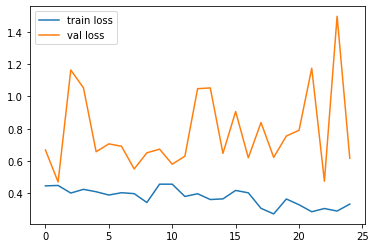

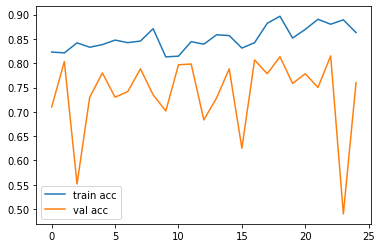

<Figure size 432x288 with 0 Axes>

In [121]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
train = pd.read_csv("train.csv")

unique_labels = np.unique(train['Class'].tolist())
pred_labels = unique_labels[predictions]

In [ ]:
## Let's see what our classifier predicts on test images
# Random predictions
i = np.random.choice(np.arange(len(test_data)))
plt.title('{} - Predicted class : {}'.format(test['ID'].values[i], pred_labels[i]))
plt.imshow(test_data[i])

In [ ]:
# Prepare submission file
subm = pd.DataFrame({'Class':pred_labels, 'ID':test.ID})
subm.to_csv('sub4.csv', index=False)

## Conclusion

In [86]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Loss", "train Accuracy", "Validation Accuracy","epochs"]

x.add_row(["Basic CNN", 0.55, 75, 71.5,30])
x.add_row(["VGG19", 0.71, 68, 58.4,10])
x.add_row(["Resnet V1", 0.186, 93, 80,30])
x.add_row(["Resnet  V2", 0.114, 96, 81,10])
x.add_row(["Inceptionnet", 0.333, 86, 76,25])


print(x)

+--------------+-------+----------------+---------------------+--------+
|    Model     |  Loss | train Accuracy | Validation Accuracy | epochs |
+--------------+-------+----------------+---------------------+--------+
|  Basic CNN   |  0.55 |       75       |         71.5        |   30   |
|    VGG19     |  0.71 |       68       |         58.4        |   10   |
|  Resnet V1   | 0.186 |       93       |          80         |   30   |
|  Resnet  V2  | 0.114 |       96       |          81         |   10   |
| Inceptionnet | 0.333 |       86       |          76         |   25   |
+--------------+-------+----------------+---------------------+--------+


    - Resnet Model has performed better amongst all
    - Tunning of Last layers is very important in transfer learning to get efficient results in less time, like in above Resnet V1 took 30 epochs wheres as V2 took opnly 10 epochs to get better accuracy
    - Therefore increasing number of epochs may increase chances of overfitting but with tunning last layers of transer learning models we can reduce overfitting with less epochs.